In [34]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *

In [29]:
def N_in_dict(dic_files, list_N):
    
    i = 0
    for key, file in dic_files.items():
        dic_files[key] = [list_N[i], file]
        i += 1
    
    return dic_files

def Processing_SIR(file, city, N):
    df = pd.DataFrame()

    Recover = [7, 14]

    df['Date'] = file['stdDay']
    df['City'] = file['gubun']

    # 사망자
    df['Dead'] = file['deathCnt']                 # 누적 사망자

    # 감염자
    df['Inf_AC'] = file['defCnt']                  # 누적 감염자
    df['Infected'] = file['defCnt']  
    df.iloc[Recover[1]:, -1] = (df.iloc[Recover[1]:, -1]
                               .reset_index(drop = True)
                               .sub(df.iloc[:len(df)-Recover[1], -1]))
    df['Infected'] = df['Infected']-df['Dead']
    
    # 회복자
    df['Recovered'] = 0
    df.iloc[Recover[1]:, -1] = df.iloc[:len(df)-Recover[1], 3]

    # 취약자
    df['Susceptible'] = N - df['Infected'] - df['Dead'] - df['Recovered']
    df = df[['Date', 'City', 'Susceptible', 'Infected', 'Dead', 'Recovered']]
    
    # Alpha
    df['alpha'] = (df['Susceptible'].shift(-1) - df['Susceptible'])
    df['alpha'] = (-1 * N * df['alpha'])/(df['Susceptible'] * df['Infected'])
    
    # Beta
    df['beta'] = (df['Recovered'].shift(-1) - df['Recovered'])
    df['beta'] = df['beta']/df['Infected']

    # Gamma
    df['gamma'] = (df['Dead'].shift(-1) - df['Dead'])
    df['gamma'] = df['gamma']/df['Infected']

    df.loc[df['alpha'] == 0, 'alpha'] = 0
    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    return df


In [30]:
path = 'Data/Cleaned_deathCnt/*.csv'
dic_files = Load_files.load_files(path, -14, -12)

list_N = [1539277, 13527299, 3311631, 2622174, 
          1440908, 2389150, 1454068, 3353379, 
          9535432, 370439, 1122757, 2952839, 
          1834016, 1786855, 676518, 2121108, 1597774]

dic_files = N_in_dict(dic_files, list_N)

In [31]:
a = dic_files['서울'][1]
a

,deathCnt,defCnt,gubun,gubunEn,incDec,isolClearCnt,isolIngCnt,localOccCnt,overFlowCnt,qurRate,stdDay
0,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-20
1,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-21
2,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-22
3,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-23
4,0,1,서울,Seoul,1,0,1,0,1,0.0,2020-01-24
...,...,...,...,...,...,...,...,...,...,...,...
1167,6383,5991150,서울,Seoul,2523,0,0,2522,1,63544.0,2023-04-01
1168,6383,5993551,서울,Seoul,2401,0,0,2401,0,63569.0,2023-04-02
1169,6384,5994393,서울,Seoul,842,0,0,842,0,63578.0,2023-04-03
1170,6387,5997981,서울,Seoul,3588,0,0,3588,0,63616.0,2023-04-04


In [32]:
dic_final = {}
for key, file in dic_files.items():
    df_final = Processing_SIR(file[1], key, file[0])
    dic_final[key] = df_final
    df_final.to_csv(f'Data/SIR_Origin/{key}_SIR_Origin.csv', index = False)

In [33]:
df = dic_final['서울']
N = df['Susceptible'][0]
df['alpha'] = (df['Susceptible'].shift(-1) - df['Susceptible'])
df['alpha'] = (-1 * N * df['alpha'])/(df['Susceptible'] * df['Infected'])

df['beta'] = (df['Recovered'].shift(-1) - df['Recovered'])
df['beta'] = df['beta']/df['Infected']

df['gamma'] = (df['Dead'].shift(-1) - df['Dead'])
df['gamma'] = df['gamma']/df['Infected']

df.loc[df['alpha'] == 0, 'alpha'] = 0
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

df

,Date,City,Susceptible,Infected,Dead,Recovered,alpha,beta,gamma
0,2020-01-20,서울,9535432,0,0,0,0.000000,0.000000,0.000000
1,2020-01-21,서울,9535432,0,0,0,0.000000,0.000000,0.000000
2,2020-01-22,서울,9535432,0,0,0,0.000000,0.000000,0.000000
3,2020-01-23,서울,9535432,0,0,0,0.000000,0.000000,0.000000
4,2020-01-24,서울,9535431,1,0,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
1167,2023-04-01,서울,3544282,25006,6383,5959761,0.258321,0.074782,0.000000
1168,2023-04-02,서울,3541881,25537,6383,5961631,0.088766,0.026980,0.000039
1169,2023-04-03,서울,3541039,25689,6384,5962320,0.376110,0.110631,0.000117
1170,2023-04-04,서울,3537451,26432,6387,5965162,0.341943,0.103019,0.000113


,Date,City,Susceptible,Infected,Dead,Recovered,alpha,beta,gamma
1162,2023-03-27,서울,3557694,22168,6376,5949194,0.376741,0.108174,0.000000
1163,2023-03-28,서울,3554578,22886,6376,5951592,0.348245,0.101022,0.000044
1164,2023-03-29,서울,3551607,23544,6377,5953904,0.311884,0.084055,0.000085
1165,2023-03-30,서울,3548872,24298,6379,5955883,0.274461,0.081817,0.000123
1166,2023-03-31,서울,3546390,24789,6382,5957871,0.228647,0.076243,0.000040
1167,2023-04-01,서울,3544282,25006,6383,5959761,0.258321,0.074782,0.000000
1168,2023-04-02,서울,3541881,25537,6383,5961631,0.088766,0.026980,0.000039
1169,2023-04-03,서울,3541039,25689,6384,5962320,0.376110,0.110631,0.000117
1170,2023-04-04,서울,3537451,26432,6387,5965162,0.341943,0.103019,0.000113
1171,2023-04-05,서울,3534098,27059,6390,5967885,0.000000,0.000000,0.000000


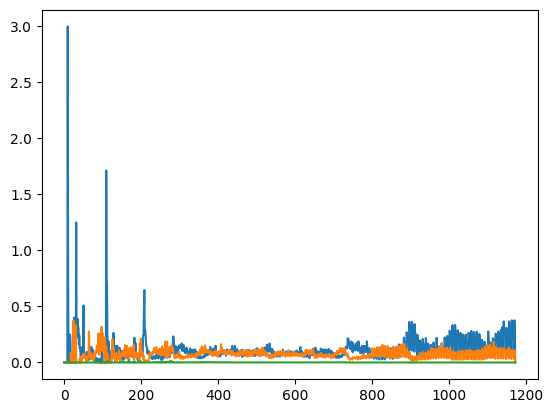

In [18]:
plt.plot(df['alpha'])
plt.plot(df['beta'])
plt.plot(df['gamma'])






df[-10:]

In [19]:
df.loc[df['beta'] < 0]

,Date,City,Susceptible,Infected,Dead,Recovered,alpha,beta,gamma


In [20]:
print(df['alpha'].describe())
print(df['beta'].describe())
print(df['gamma'].describe())

count    1172.000000
mean        0.118286
std         0.128768
min         0.000000
25%         0.067831
50%         0.094859
75%         0.138825
max         3.000000
Name: alpha, dtype: float64
count    1172.000000
mean        0.077500
std         0.041103
min         0.000000
25%         0.053144
50%         0.075949
75%         0.099636
max         0.375000
Name: beta, dtype: float64
count    1172.000000
mean        0.000498
std         0.001282
min         0.000000
25%         0.000000
50%         0.000064
75%         0.000497
max         0.016393
Name: gamma, dtype: float64


In [97]:
df[80:120]

,Date,City,Susceptible,Infected,Dead,Recovered,alpha,beta
80,2020-04-09,서울,9534842,230,2,358,0.021740,0.052174
81,2020-04-10,서울,9534837,223,2,370,0.017938,0.080717
82,2020-04-11,서울,9534833,209,2,388,0.014355,0.095694
83,2020-04-12,서울,9534830,192,2,408,0.041669,0.083333
84,2020-04-13,서울,9534822,184,2,424,0.010870,0.130435
85,2020-04-14,서울,9534820,162,2,448,0.030866,0.148148
86,2020-04-15,서울,9534815,143,2,472,0.013987,0.097902
87,2020-04-16,서울,9534813,131,2,486,0.015268,0.137405
88,2020-04-17,서울,9534811,115,2,504,0.008696,0.191304
89,2020-04-18,서울,9534810,94,2,526,0.021278,0.255319


In [101]:
dic_files['서울'][1][80:120]

,deathCnt,defCnt,gubun,gubunEn,incDec,isolClearCnt,isolIngCnt,localOccCnt,overFlowCnt,qurRate,stdDay
80,2,590,서울,Seoul,12,168,420,3,9,6.06,2020-04-09
81,2,595,서울,Seoul,5,178,415,3,2,6.11,2020-04-10
82,2,599,서울,Seoul,4,188,409,1,3,6.15,2020-04-11
83,2,602,서울,Seoul,3,195,405,2,1,6.18,2020-04-12
84,2,610,서울,Seoul,8,206,402,1,7,6.27,2020-04-13
85,2,612,서울,Seoul,2,220,390,0,2,6.29,2020-04-14
86,2,617,서울,Seoul,5,230,385,1,4,6.34,2020-04-15
87,2,619,서울,Seoul,2,240,377,1,1,6.36,2020-04-16
88,2,621,서울,Seoul,2,258,361,1,1,6.38,2020-04-17
89,2,622,서울,Seoul,1,265,355,0,1,6.39,2020-04-18


In [38]:
dic_files

NameError: name 'x_ss' is not defined

In [37]:
input_size = x_ss.size(2)
num_layers = 1
hidden_size = 16
sequence_length = 60

model = RNN(input_size = input_size,
           hidden_size = hidden_size,
           sequence_length = sequence_length,
           num_layers = num_layers, 
           dropout = 0.3, 
           device = device).to(device)

NameError: name 'x_ss' is not defined